In [1]:
import numpy as np
import os.path as osp
import os
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 
import sys

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)

from dataset.kitti_odometry_dataset import KittiOdometryDataset, KittiOdometryDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

from hidden_points_removal import hidden_point_removal_o3d, BiasuttiVisibility
from point_cloud_utils import project_pcd, filter_points_from_dict, get_pcd
from point_to_pixels import point_to_pixel
from visualization_utils import unite_pcd_and_img

In [2]:
DATASET_PATH = os.path.join('/Users/laurenzheidrich/Downloads/','fused_dataset')
SEQUENCE_NUM = 4

config_filtered = KittiOdometryDatasetConfig(
    cache=True,
    dataset_path=DATASET_PATH,
    correct_scan_calibration=True,
    filters=FilterList(
        [
            KittiGTMovingObjectFilter(
                os.path.join(
                    DATASET_PATH,
                    "sequences",
                    "%.2d" % SEQUENCE_NUM,
                    "labels",
                )
            ),
            RangeFilter(2.5, 120),
            ApplyPose(),
        ]
    ),
)

dataset = KittiOdometryDataset(config_filtered, SEQUENCE_NUM)

In [3]:
points_index = 150
cam_name = "cam2"

pcd_o3d = get_pcd(dataset.get_point_cloud(points_index))
pcd = np.asarray(pcd_o3d.points)

image_PIL = dataset.get_image(cam_name, points_index)

image = cv2.cvtColor(np.array(image_PIL), cv2.COLOR_RGB2BGR)

In [4]:
T_lidar2cam, K_cam2 = dataset.get_projection_matrices(cam_name)
pcd_camframe = project_pcd(pcd, T_lidar2cam)

In [5]:
hpr_mode = "o3d" # "o3d" or "biscutti"

if hpr_mode == "o3d":
    #Camera set to [0,0,0] because we are already in camera frame and camera position is origin
    hpr_mask = hidden_point_removal_o3d(pcd_camframe, camera=[0,0,0], radius_factor=500) 
elif hpr_mode == "biscutti":
    biscutti = BiasuttiVisibility(pcd_camframe, n_neighbours=64)
    hpr_mask = biscutti.at_image()

pcd_camframe_hpr = pcd_camframe[hpr_mask]
pcd_hpr = pcd[hpr_mask]

In [6]:
# Here I need to check why pcd is needed and what effect that has on the result
point_to_pixel_dict = point_to_pixel(pcd_camframe, K_cam2, image.shape[0], image.shape[1])

point_to_pixel_dict_hpr = point_to_pixel(pcd_camframe_hpr, K_cam2, image.shape[0], image.shape[1])

In [7]:
pcd_camframe_fov = filter_points_from_dict(pcd, point_to_pixel_dict)
pcd_camframe_fov_hpr = filter_points_from_dict(pcd_hpr, point_to_pixel_dict_hpr)

In [8]:
print("Number of points in initial point cloud: ", pcd.shape[0])
print("Number of points after Hidden Point Removal: ", pcd_hpr.shape[0])
print("Number of points projected on image without Hidden Point Removal: ", len(point_to_pixel_dict))
print("Number of points projected on image with Hidden Point Removal: ", len(point_to_pixel_dict_hpr))

Number of points in initial point cloud:  126941
Number of points after Hidden Point Removal:  118900
Number of points projected on image without Hidden Point Removal:  20607
Number of points projected on image with Hidden Point Removal:  19557


In [9]:
img_overlay = unite_pcd_and_img(point_to_pixel_dict, pcd_camframe, image)

img_overlay_hpr = unite_pcd_and_img(point_to_pixel_dict_hpr, pcd_camframe_hpr, image)

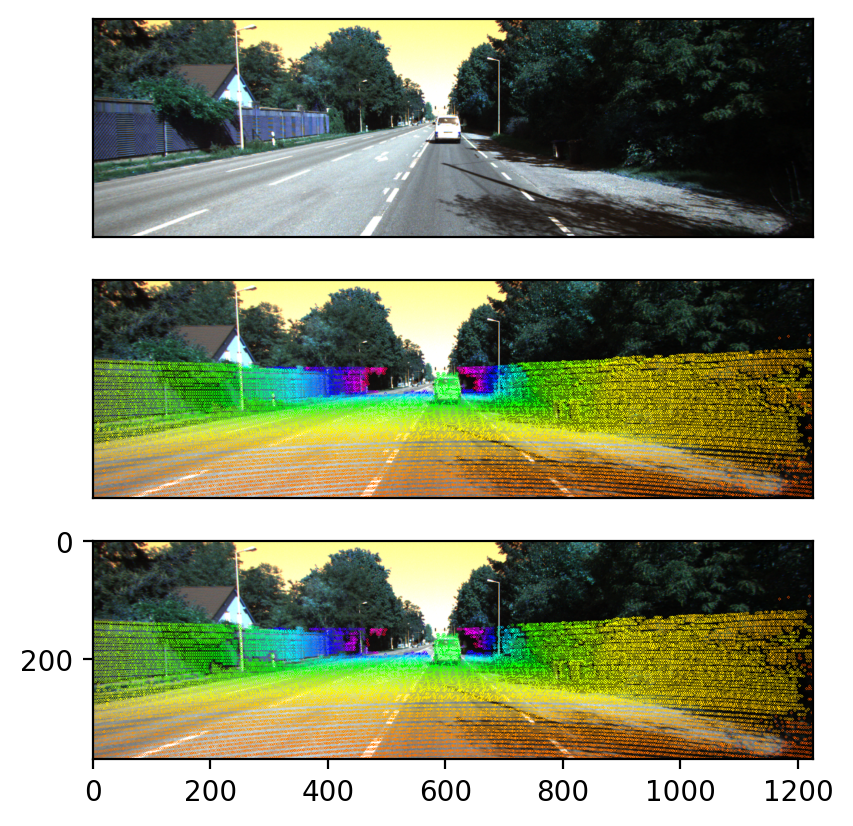

In [10]:
# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Display images in subplots
ax1.imshow(image)
ax2.imshow(img_overlay)
ax3.imshow(img_overlay_hpr)

# Hide the axes ticks and labels
ax1.set_xticks([]), ax1.set_yticks([])
ax2.set_xticks([]), ax2.set_yticks([])

fig.set_dpi(200)

plt.show()

In [ ]:
vis_pcd = get_pcd(pcd_camframe_fov_hpr)

o3d.visualization.draw_geometries([vis_pcd])